## Imports

In [15]:
# env
import gym

# utils
import imageio
from IPython.display import Image, HTML, clear_output
import logging
import matplotlib.pyplot as plt
import numpy as np

# model
import tensorflow as tf
from tensorflow.keras import backend as K

saveImgs = False

%matplotlib inline 

## Get CartPole env

In [16]:
env = gym.make('CartPole-v1')
env._max_episode_steps = 250
gym.logger.setLevel(logging.ERROR)

## Useful functions

In [ ]:
def run_episodes(env, policy):
    frames = []
    observation = env.reset()
    done = False
    while not done:
        frames.append(env.render(mode='rgb_array'))
        if hasattr(policy, 'model'):
            action = policy.decide(observation)
        else:
            action = policy(env, observation)
        observation, reward, done, info = env.step(action)
    return frames

## Random policy test

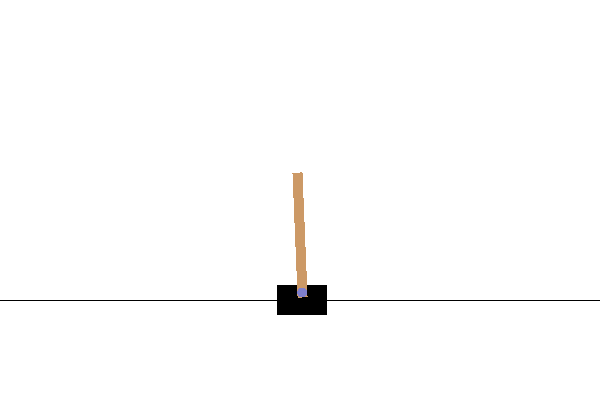

In [ ]:
def random_policy(env, observation):
    return env.action_space.sample()
episodes = run_episodes(env, random_policy)
if saveImgs:
    imageio.mimsave('imgs/cartpole_random_policy.gif', episodes, fps=45)
Image("imgs/cartpole_random_policy.gif")

## Training loop

In [17]:
def training(agent, env, number_of_episodes=450,
             saveEpisodeInterval = 75, printRewardInterval = 20):

    rewards_per_episode = []
    frames_per_episode = []
    best_sum_reward = -1

    for episode_idx in range(number_of_episodes):

        # print previous episode results at wanted interval
        if (episode_idx+1) % printRewardInterval == 0:
            clear_output()
            plt.xlim(0, number_of_episodes)
            plt.plot(rewards_per_episode)
            plt.pause(0.0001)
            print(f"Episode n°{episode_idx}: {sum_rewards} rewards")
    
        # reset episode var
        frames = None
        state = env.reset()
        sum_rewards = 0

        # save frames at wanted interval
        if (episode_idx+1) % saveEpisodeInterval == 0:
            frames = []

        while True:

            # save frames at wanted interval
            if frames is not None:
                frames.append(env.render(mode='rgb_array'))

            # Take action
            action = agent.decide(state)
            next_state, reward, done, info = env.step(action)
            sum_rewards += reward

            # Store information for training
            agent.observe(state, action, reward)

            # Train agent with observed episode
            if done:
                rewards_per_episode.append(sum_rewards)

                # save frames at wanted interval
                if frames is not None:
                    frames_per_episode.append(frames)

                # train agent
                agent.train()
                break

            state = next_state
        if best_sum_reward <= sum_rewards:
            best_sum_reward = sum_rewards
            agent.model.save("cartpole_rl_agent")

            
    return frames_per_episode, agent

In [18]:
class Agent(object):
    
    def __init__(self, n_obs, n_act, policy_learning_rate, discount):

        # agent attributes
        self.n_obs = n_obs  
        self.n_act = n_act
        self.gamma = discount

        # parameters
        self.policy_learning_rate = policy_learning_rate

        # observations
        self.reset_observation_lists()

        # build network
        self.model = tf.keras.models.Sequential([
               # take as input the observations
               tf.keras.layers.Dense(16, input_dim=self.n_obs,
                                     activation="relu"),
               tf.keras.layers.Dense(16, activation="relu"),
               tf.keras.layers.Dense(16, activation="relu"),
               # output a policy distribution
               tf.keras.layers.Dense(self.n_act, activation='softmax')
        ])
        
        opt = tf.keras.optimizers.Adam(lr=self.policy_learning_rate)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy')

    def observe(self, state, action, reward):
        """
        Save state, action and reward to agent memory

        Args:
          - (object) environment-specific object representing the observation
          - (float) action that the agent did
          - (float) reward that the agent got
        """
        self.episode_observations.append(state)
        self.episode_actions.append(action)
        self.episode_rewards.append(reward)
        
    def decide(self, state):
        """ 
        Get prediction from model with the observed state
        Choose an action from the output distribution

        Args:
            - (object) environment-specific object representing the observation
        
        Return:
            - (int) action to take
        """
        
        output = self.model.predict(state.reshape(-1, self.n_obs))
        choice = np.random.choice(self.n_act, p=output.reshape(-1))
        self.probability_action.append(output.reshape(-1)[choice])
        return choice

    def train(self):
        """ Train model with discounted reward and reset observations lists """
    
        discounted_reward = self.get_discounted_reward()
        actions_one_hot_encoding = np.array(
            tf.keras.utils.to_categorical(self.episode_actions, self.n_act))
        state = np.array(self.episode_observations)

        history = self.model.train_on_batch(state.reshape(-1, self.n_obs),
                                            actions_one_hot_encoding,
                                            sample_weight=discounted_reward)
        self.reset_observation_lists()

    def reset_observation_lists(self):
        self.episode_observations = []
        self.episode_actions = []
        self.episode_rewards = []
        self.probability_action = []

    def get_discounted_reward(self):
        """ Return discounted episode returns at each step in the episode """
        rewards = np.array(self.episode_rewards)
        discounted_rewards = np.zeros_like(rewards)
        sum = 0

        for t in reversed(range(0, len(rewards))):
            sum = sum * self.gamma + rewards[t]
            discounted_rewards[t] = sum

        return discounted_rewards

    def load(self, path):
        """ Method to load agent that was already trained """
        self.model = tf.keras.models.load_model(path)


In [21]:
agent = Agent(n_obs = env.observation_space.shape[0],
              n_act = env.action_space.n,
              policy_learning_rate = 0.002, 
              discount=0.99)

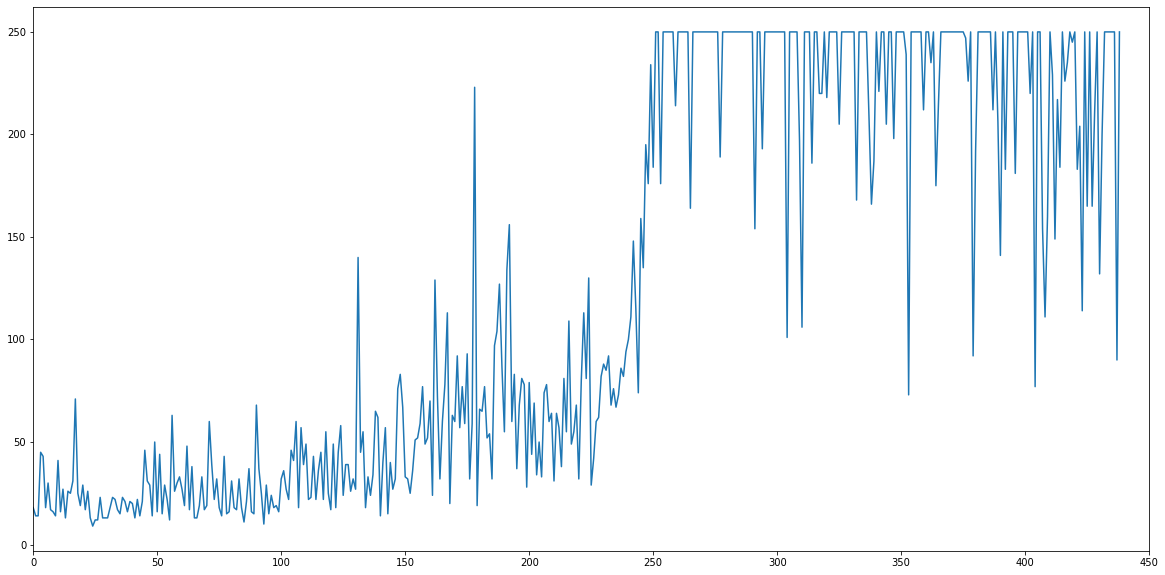

Episode n°439: 250.0 rewards
INFO:tensorflow:Assets written to: cartpole_rl_agent/assets
INFO:tensorflow:Assets written to: cartpole_rl_agent/assets
INFO:tensorflow:Assets written to: cartpole_rl_agent/assets
INFO:tensorflow:Assets written to: cartpole_rl_agent/assets


In [22]:
plt.rcParams["figure.figsize"] = (20, 10)

episodes, agent = training(agent, env)

In [ ]:
!zip -r /content/cartpole_agent.zip cartpole_rl_agent
from google.colab import files
files.download("/content/cartpole_agent.zip")

  adding: cartpole_rl_agent/ (stored 0%)
  adding: cartpole_rl_agent/assets/ (stored 0%)
  adding: cartpole_rl_agent/saved_model.pb (deflated 89%)
  adding: cartpole_rl_agent/variables/ (stored 0%)
  adding: cartpole_rl_agent/variables/variables.index (deflated 67%)
  adding: cartpole_rl_agent/variables/variables.data-00000-of-00001 (deflated 35%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Final model after 3k episodes

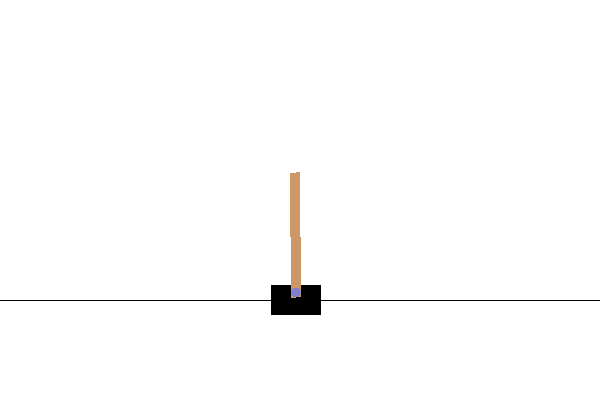

In [ ]:
agent = Agent(n_obs = env.observation_space.shape[0],
              n_act = env.action_space.n,
              policy_learning_rate = 0.002, 
              discount=0.99, entropy_cost = 0, max_ent_cost = 0)
agent.load("cartpole_rl_agent")

episodes = run_episodes(env, agent)
if saveImgs:
    imageio.mimsave('imgs/cartpole_agent_750_episodes.gif', episodes, fps=45)
Image("imgs/cartpole_agent_750_episodes.gif")